## Setup

In [63]:
# install dependencies
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [64]:
# variables
KURTOSIS_WINDOW = "720D"
DATA_FILE = 'crsp.csv'
FAMA_FRENCH_FACTORS = 'F-F_Research_Data_Factors.csv'

In [65]:
# preprocessing

src = pd.read_csv(DATA_FILE)

src = src[['permno', 'comnam', 'date', 'prc', 'ret', 'dlret']]

src['ret'] = pd.to_numeric(src['ret'], errors='coerce')
src['date'] = pd.to_datetime(src['date'], format='%Y%m%d')

/tmp/ipykernel_5484/1447945420.py:3: DtypeWarning: Columns (5,6,7,10,18,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  src = pd.read_csv(DATA_FILE)


## Experiment

In [66]:
def calculate_kurtosis(frame: pd.DataFrame):
    frame = frame.copy()  
    frame['kurtosis'] = None 

    for _, group in frame.groupby('permno'):
        k = group.set_index('date')['ret'].rolling(window=KURTOSIS_WINDOW).kurt()
        frame.loc[group.index, 'kurtosis'] = k.values

    return frame.dropna(subset=['kurtosis'])

In [67]:
# calculate kurtosis
df = calculate_kurtosis(src)

In [68]:
# Extract unique months
df['month_year'] = df['date'].dt.to_period('M')
df = df[df['month_year'] >= pd.Period('1926-07', freq='M')]
months = df['month_year'].unique()

##### Plotted curtosis of 15 stocks (1990-2025)

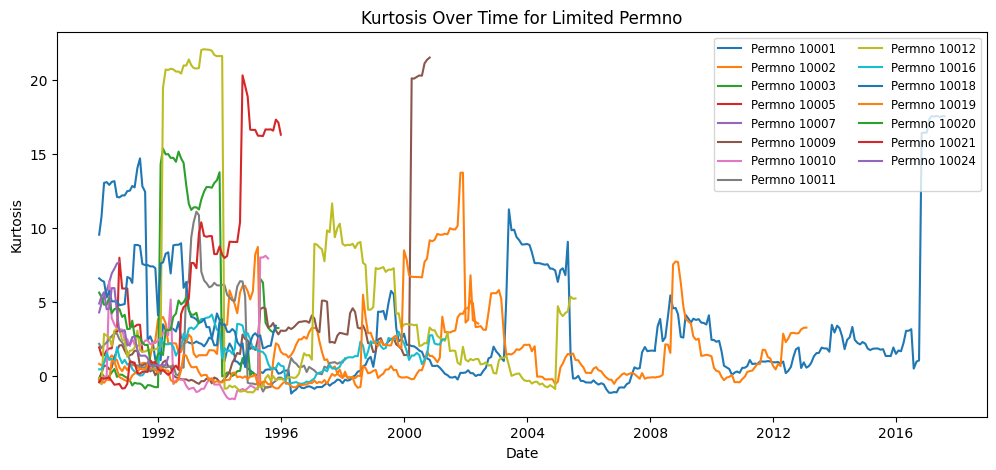

In [69]:
def plot_kurtosis_over_time_limited_filtered(data, limit=15):
    plt.figure(figsize=(12, 5))  
    filtered_data = data[(data['date'] >= '1990-01-01') & (data['date'] <= '2025-12-31')]
    for permno, group in filtered_data.groupby('permno'):
        plt.plot(group['date'], group['kurtosis'], label=f'Permno {permno}')
        limit -= 1
        if limit == 0:
            break
    plt.xlabel('Date')
    plt.ylabel('Kurtosis')
    plt.title('Kurtosis Over Time for Limited Permno')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.show()

# Plot kurtosis 
plot_kurtosis_over_time_limited_filtered(df)

##### Mean return of each quantile (all-time)

In [70]:
def assign_quantiles(data: pd.DataFrame, field):
    sorted_df = data.sort_values(by=field)
    sorted_df['quantile'] = pd.qcut(sorted_df[field], q=10, labels=False)
    return sorted_df

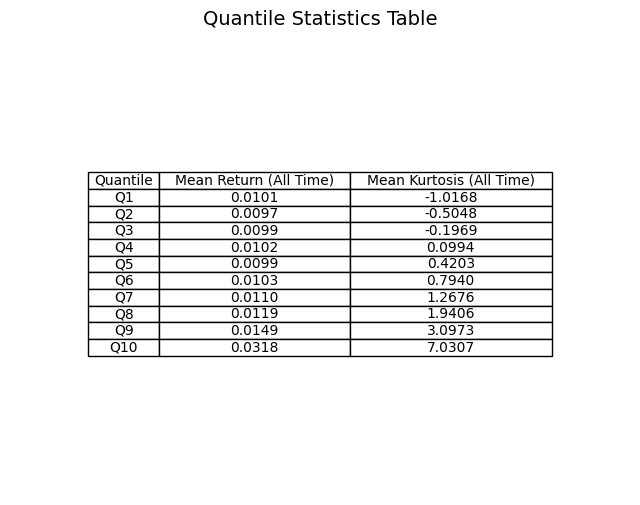

In [71]:
# measure mean return and mean kurtosis of quantiles through time 

quantile_means = []
quantile_kurtosis = []

for i in range(10):
    mean_returns = []
    mean_kurtosis = []

    # Iterate over unique months
    for month in months:
        month_data = df[df['month_year'] == month]
        quantiles = assign_quantiles(month_data, "kurtosis")

        mean_returns.append(quantiles[quantiles['quantile'] == i]['ret'].mean())
        mean_kurtosis.append(quantiles[quantiles['quantile'] == i]['kurtosis'].mean())

    quantile_means.append(pd.Series(mean_returns).mean())
    quantile_kurtosis.append(pd.Series(mean_kurtosis).mean())

# create table 
data = [[f"Q{i+1}", f"{quantile_means[i]:.4f}", f"{quantile_kurtosis[i]:.4f}"] for i in range(10)]

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=data,
    colLabels=["Quantile", "Mean Return (All Time)", "Mean Kurtosis (All Time)"],
    loc="center",
    cellLoc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(data[0]))))

plt.title("Quantile Statistics Table", fontsize=14)
plt.show()

Appears that quantiles with higher curtosis, when viewed as portfolios, perform better than quantiles with lower curtosis.

#### Portfolio generation 

In [72]:
# creating portfolios for next month
def create_portfolio(data: pd.DataFrame, long: list, short: list):
    quantiles = assign_quantiles(data, "kurtosis")

    portfolio = pd.concat(quantiles[quantiles['quantile'] == q] for q in (long + short))
    portfolio = portfolio[['permno', 'comnam', 'date']]

    return portfolio 

# get return in next month
def get_return(portfolio: pd.DataFrame, next_month: pd.DataFrame):
    portfolio = pd.merge(portfolio, next_month[['permno', 'ret', 'dlret']], on='permno', how='left')

    portfolio['ret'] = pd.to_numeric(portfolio['ret'], errors='coerce')
    portfolio['next_month_return'] = portfolio['ret'].fillna(portfolio['dlret']).fillna(0)

    return portfolio['next_month_return'].mean()

In [73]:
# Generate time series for port_small and port_large
portfolio_small_returns = []
portfolio_large_returns = []
quantile_returns = {q: [] for q in range(10)}

for month in months[:-1]:
    next_month = month + 1

    month_data = df[df['month_year'] == month].copy()
    next_month_data = df[df['month_year'] == next_month].copy()

    month_data = assign_quantiles(month_data, "kurtosis")

    portfolio_small = create_portfolio(month_data, [9], [0])
    portfolio_large = create_portfolio(month_data, [9, 8], [0, 1])

    # get quantile and portfolio returns
    for q in range(10):
        quantile_data = month_data[month_data['quantile'] == q]
        quantile_returns[q].append(
            (month, get_return(quantile_data[['permno', 'comnam', 'date']], next_month_data))
        )

    portfolio_small_returns.append((month, get_return(portfolio_small, next_month_data)))
    portfolio_large_returns.append((month, get_return(portfolio_large, next_month_data)))

# Create time series
port_small_series = pd.Series(
    dict(portfolio_small_returns)
).sort_index()

port_large_series = pd.Series(
    dict(portfolio_large_returns)
).sort_index()

quantile_series = {
    q: pd.Series(dict(returns)).sort_index() for q, returns in quantile_returns.items()
}


/tmp/ipykernel_5484/2093064416.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['next_month_return'] = portfolio['ret'].fillna(portfolio['dlret']).fillna(0)
/tmp/ipykernel_5484/2093064416.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['next_month_return'] = portfolio['ret'].fillna(portfolio['dlret']).fillna(0)
/tmp/ipykernel_5484/2093064416.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-i

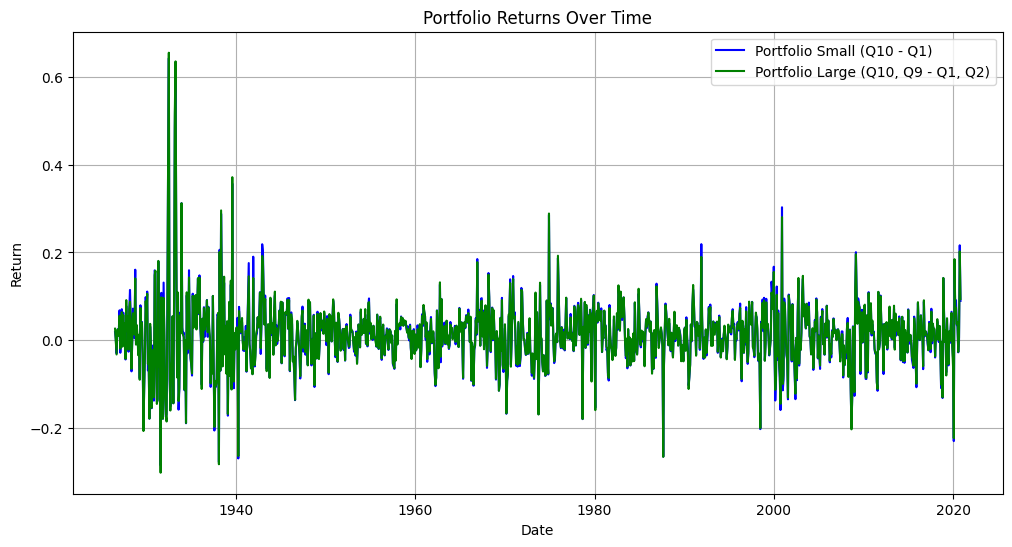

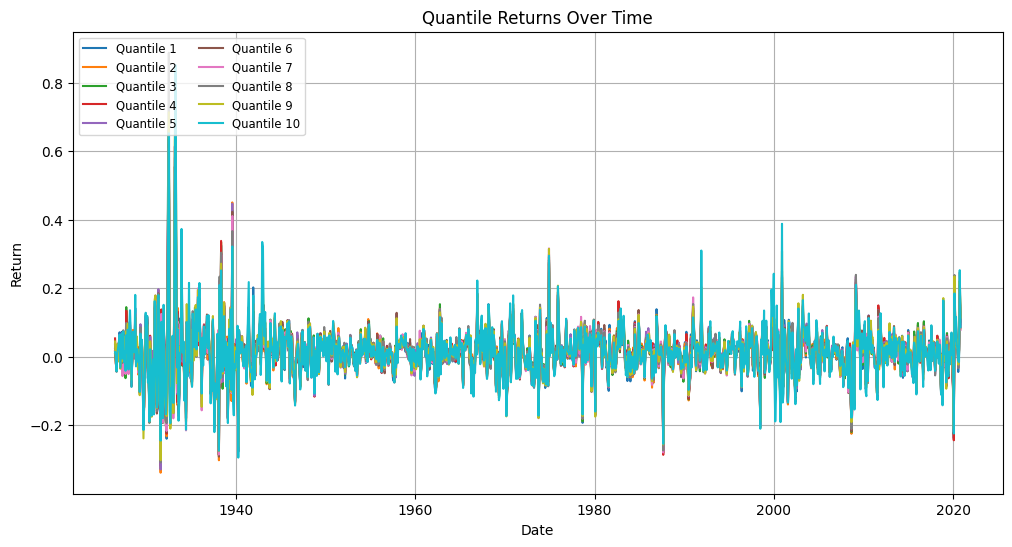

In [74]:
# Plot portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(port_small_series.index.to_timestamp(), port_small_series.values, label="Portfolio Small (Q10 - Q1)", color="blue")
plt.plot(port_large_series.index.to_timestamp(), port_large_series.values, label="Portfolio Large (Q10, Q9 - Q1, Q2)", color="green")
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Portfolio Returns Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot quantile returns_
plt.figure(figsize=(12, 6))
for q, series in quantile_series.items():
    plt.plot(series.index.to_timestamp(), series.values, label=f"Quantile {q+1}")
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Quantile Returns Over Time")
plt.legend(loc="upper left", fontsize="small", ncol=2)
plt.grid()
plt.show()

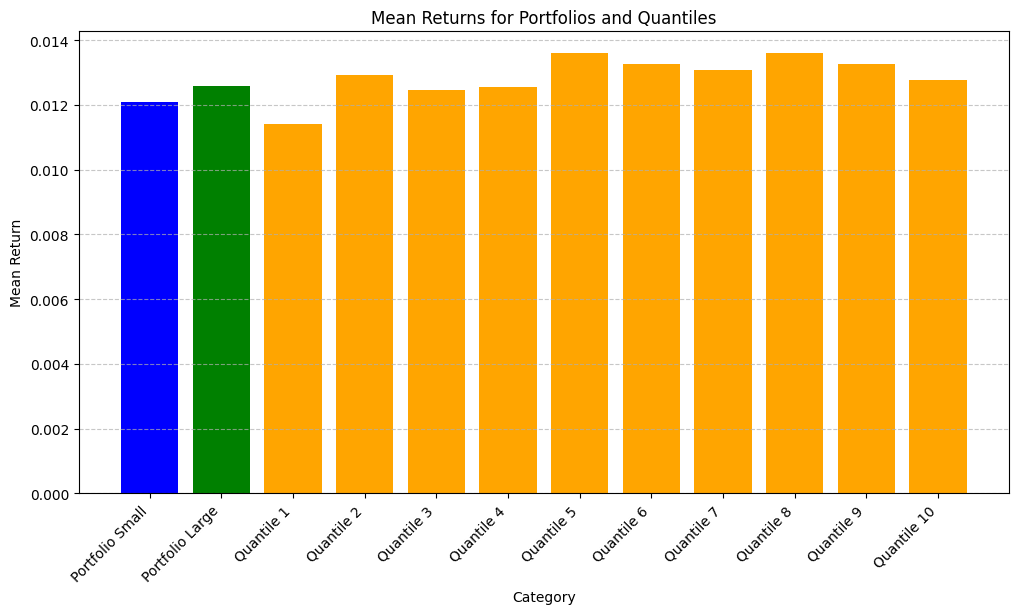

In [75]:
# plot mean return for each quantile and portfolio
mean_port_small = port_small_series.mean()
mean_port_large = port_large_series.mean()
mean_quantiles = {q: series.mean() for q, series in quantile_series.items()}

labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
means = [mean_port_small, mean_port_large] + [mean_quantiles[q] for q in range(10)]

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=["blue", "green"] + ["orange"] * 10)
plt.xlabel("Category")
plt.ylabel("Mean Return")
plt.title("Mean Returns for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Portfolio evaluation

In [87]:
# load fama french factors
ff_factors = pd.read_csv(FAMA_FRENCH_FACTORS)

ff_factors['month_year'] = pd.to_datetime(ff_factors['Date'], format='%Y%m').dt.to_period('M')
ff_factors = ff_factors[['month_year', 'MKT_RF', 'SMB', 'HML', 'RF']]

# Adjust scale of factors
ff_factors['MKT_RF'] = ff_factors['MKT_RF'] / 100
ff_factors['SMB'] = ff_factors['SMB'] / 100
ff_factors['HML'] = ff_factors['HML'] / 100
ff_factors['RF'] = ff_factors['RF'] / 100

In [88]:
def print_alpha(model, desc):
    print(f"{desc} - Alpha: {model.params['const']:.4f}, t-stat: {model.tvalues['const']:.4f}")

# define famma french
def fama_french(data: pd.Series, factors):
    # Load Fama-French factors
    data = data.reset_index()  
    data.columns = ['month_year', 'ret']  

    # match date with factors
    factors = factors[factors['month_year'].isin(data['month_year'])]
    regression_in = pd.merge(data, factors, on='month_year', how='left')

    # Compute excess return
    regression_in['excess_return'] = regression_in['ret'] - regression_in['RF']

    # Prepare regression variables
    X = regression_in[['MKT_RF', 'SMB', 'HML']]
    X = X.apply(pd.to_numeric, errors='raise')
    X = sm.add_constant(X, has_constant='add')

    y = pd.to_numeric(regression_in['excess_return'], errors='raise')
    regression_in['excess_return'] = regression_in['ret'] - regression_in['RF']

    # Run regression
    model = sm.OLS(y, X).fit()
    return model

In [89]:

# find alphas for portfolios
portfolio_small_model = fama_french(port_small_series, ff_factors)
portfolio_large_model = fama_french(port_large_series, ff_factors)

print_alpha(portfolio_small_model, f"Portfolio small (long Q10, short Q1)")
print_alpha(portfolio_large_model, f"Portfolio large (long Q10, Q9, short Q1, Q2)")

portfolio_alphas = [portfolio_small_model.params['const'], portfolio_large_model.params['const']]
quantile_alphas = []

portfolio_tvalues = [
    portfolio_small_model.tvalues['const'],
    portfolio_large_model.tvalues['const']
]
quantile_tvalues = []

# find alphas for quantiles
for q in range(10):
    model = fama_french(quantile_series[q], ff_factors)
    quantile_alphas.append(model.params['const'])
    quantile_tvalues.append(model.tvalues['const'])
    print_alpha(model, f"Quantile {q+1}")

Portfolio small (long Q10, short Q1) - Alpha: 0.0072, t-stat: 3.2979
Portfolio large (long Q10, Q9, short Q1, Q2) - Alpha: 0.0076, t-stat: 3.5389
Quantile 1 - Alpha: 0.0069, t-stat: 3.3097
Quantile 2 - Alpha: 0.0083, t-stat: 3.9376
Quantile 3 - Alpha: 0.0076, t-stat: 3.6146
Quantile 4 - Alpha: 0.0078, t-stat: 3.7610
Quantile 5 - Alpha: 0.0089, t-stat: 4.1078
Quantile 6 - Alpha: 0.0085, t-stat: 3.9824
Quantile 7 - Alpha: 0.0084, t-stat: 3.9007
Quantile 8 - Alpha: 0.0082, t-stat: 3.7131
Quantile 9 - Alpha: 0.0079, t-stat: 3.5010
Quantile 10 - Alpha: 0.0075, t-stat: 3.1470


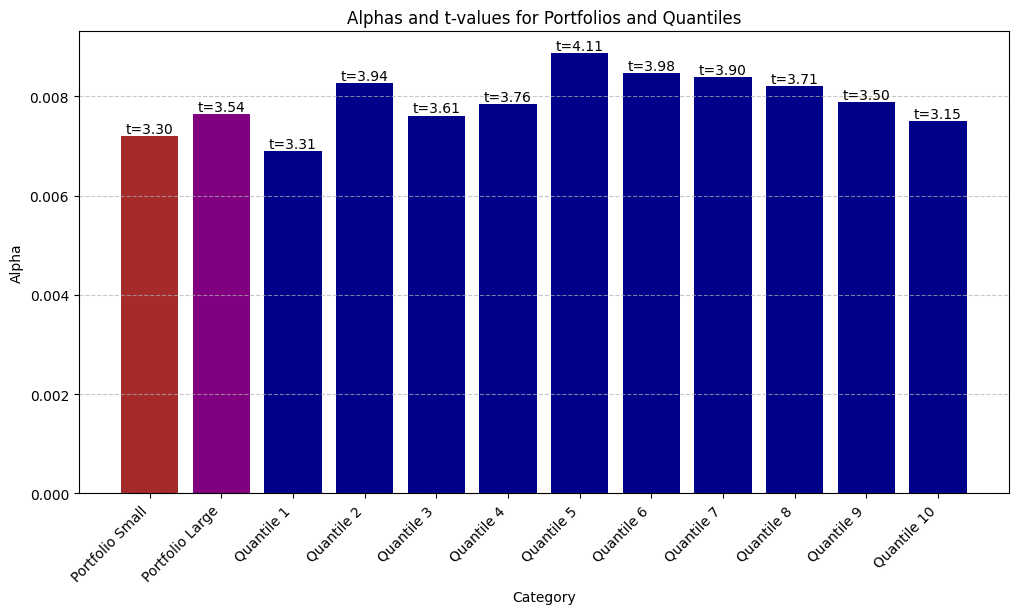

In [90]:
# create charts 
labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
alphas = portfolio_alphas + quantile_alphas
tvalues = portfolio_tvalues + quantile_tvalues

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, alphas, color=["brown", "purple"] + ["darkblue"] * 10)

for bar, alpha, tvalue in zip(bars, alphas, tvalues):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"t={tvalue:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Category")
plt.ylabel("Alpha")
plt.title("Alphas and t-values for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [91]:
# define sharpe ratio
def sharpe_ratio(data: pd.Series, factors):
    data = data.reset_index()  
    data.columns = ['month_year', 'ret']  

    # match date with factors
    factors = factors[factors['month_year'].isin(data['month_year'])]
    returns_in = pd.merge(data, factors, on='month_year', how='left')

    # Compute excess return
    returns_in['excess_return'] = returns_in['ret'] - returns_in['RF']

    # return sharpe ratio
    return returns_in['excess_return'].mean() / returns_in['excess_return'].std()

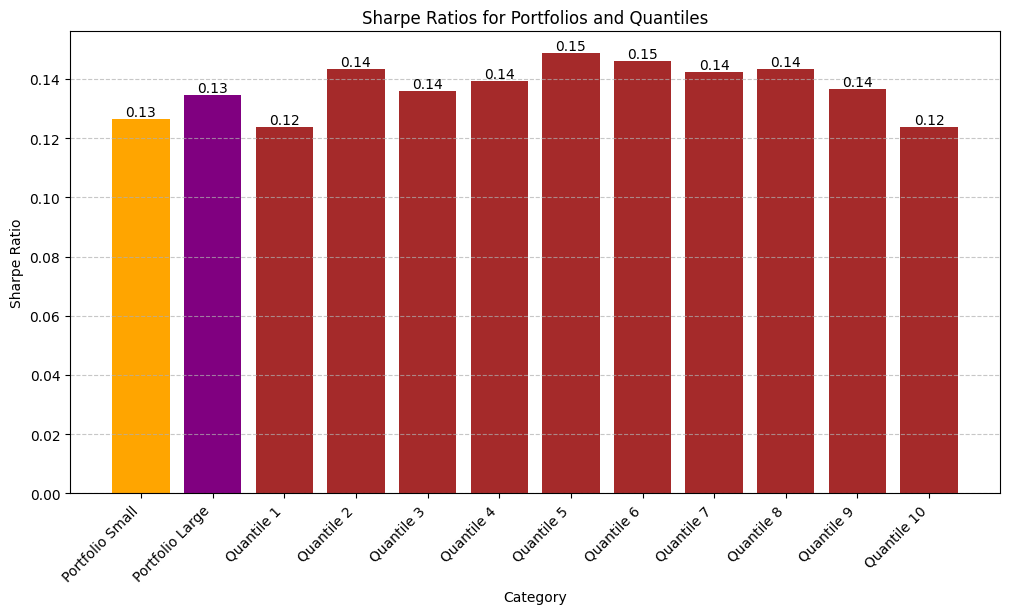

In [92]:
# calculate sharpe ratio for portfolios and quantiles
portfolio_small_sharpe = sharpe_ratio(port_small_series, ff_factors)
portfolio_large_sharpe = sharpe_ratio(port_large_series, ff_factors)
quantile_sharpe = [sharpe_ratio(quantile_series[q], ff_factors) for q in range(10)]

# create bar chart for sharpe ratio
labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
sharpe_values = [portfolio_small_sharpe, portfolio_large_sharpe] + quantile_sharpe   
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, sharpe_values, color=["orange", "purple"] + ["brown"] * 10)
for bar, tvalue in zip(bars, sharpe_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{tvalue:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )
plt.xlabel("Category")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratios for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

##### Misc

In [93]:
# generate portfolio for next month (from now)
month = months[-1]
month_data = df[df['month_year'] == month]

portfolio_small = create_portfolio(month_data, [9], [0])
portfolio_large = create_portfolio(month_data, [9,8], [0,1])

print("Portfolio Small:", portfolio_small.head())
print("Portfolio Large:", portfolio_large.head())

Portfolio Small:          permno                    comnam       date
3588066   16181                PAVMED INC 2020-12-31
3587650   14433  DEL TACO RESTAURANTS INC 2020-12-31
3587495   13625          SHUTTERSTOCK INC 2020-12-31
3589265   47626      C N A FINANCIAL CORP 2020-12-31
3588056   16140                TWILIO INC 2020-12-31
Portfolio Large:          permno                    comnam       date
3588066   16181                PAVMED INC 2020-12-31
3587650   14433  DEL TACO RESTAURANTS INC 2020-12-31
3587495   13625          SHUTTERSTOCK INC 2020-12-31
3589265   47626      C N A FINANCIAL CORP 2020-12-31
3588056   16140                TWILIO INC 2020-12-31
